In [1]:
import geopandas as gpd
from glob import glob
import pandas as pd

files = sorted(glob("../PASTIS/PASTIS/*.geojson"))  # o "*.gpkg"

gdfs = [gpd.read_file(fp) for fp in files]
gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# garantizar columna parcel_id
if "parcel_id" not in gdf.columns:
    for cand in ["id", "ID", "parcel", "ParcelID", "parcelId"]:
        if cand in gdf.columns:
            gdf = gdf.rename(columns={cand: "parcel_id"})
            break
    if "parcel_id" not in gdf.columns:
        gdf["parcel_id"] = range(1, len(gdf) + 1)

# a WGS84
gdf = gdf.to_crs(4326)

# centroides
gdf["lon"] = gdf.geometry.centroid.x
gdf["lat"] = gdf.geometry.centroid.y

# si existe columna tile_id o class, la conservamos
cols = [c for c in ["parcel_id", "tile_id", "class", "lon", "lat"] if c in gdf.columns]
if "parcel_id" not in cols: cols = ["parcel_id"] + cols
if "lon" not in cols: cols += ["lon", "lat"]

gdf[cols].to_csv("pastis_parcel_coords_all.csv", index=False)

print(gdf[cols].head())
print("Listo: pastis_parcel_coords_all.csv")



  parcel_id       lon        lat
0     10000 -1.261678  49.629423
1     10001 -1.530744  48.930774
2     10002 -1.297111  49.629950
3     10003 -0.357606  49.301395
4     10004 -1.593171  49.196391
Listo: pastis_parcel_coords_all.csv


C:\Users\LuisA\AppData\Local\Temp\ipykernel_21324\3902720773.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
C:\Users\LuisA\AppData\Local\Temp\ipykernel_21324\3902720773.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


In [ ]:
import ee

# 1) Lanza el flujo OAuth y elige el proyecto para autenticar.
ee.Authenticate()  # sigue el enlace que aparece y concede permisos

# 2) Inicializa la sesión indicando tu Cloud Project (ID).
ee.Initialize(project='fonseca-472504')

# 3) Prueba mínima: hace una llamada al servidor.
print('EE responde:', ee.Number(1).getInfo())


EE responde: 1


In [3]:
import ee

# Parámetros de entrada (cámbialos):
lon, lat = -1.261678,  49.629423   # longitud, latitud (EPSG:4326)
year = 2019                   # año del embedding: 2017..2024

pt = ee.Geometry.Point([lon, lat])

# 1) Selecciona la imagen anual de embeddings que cubre el punto y el año
img = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate(f'{year}-01-01', f'{year+1}-01-01')
       .filterBounds(pt)
       .first())

# 2) Extrae los valores de las 64 bandas en el punto (escala 10 m)
#    -> Devuelve un dict con claves A00..A63 y valores float (unit-length)
vec64 = img.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=pt,
    scale=10
).getInfo()

print(vec64)  # {'A00': ..., 'A01': ..., ..., 'A63': ...}


{'A00': -0.1929104190695886, 'A01': -0.0629911572472126, 'A02': -0.1085121107266436, 'A03': -0.0629911572472126, 'A04': 0.029773164167627833, 'A05': -0.09842368319876971, 'A06': 0.14173010380622836, 'A07': 0.01574778931180315, 'A08': 0.14173010380622836, 'A09': -0.06698961937716265, 'A10': 0.017777777777777778, 'A11': 0.2288965782391388, 'A12': -0.14173010380622836, 'A13': 0.2288965782391388, 'A14': -0.05911572472126105, 'A15': 0.08882737408688965, 'A16': -0.08421376393694734, 'A17': 0.11909265667051133, 'A18': -0.05173394848135333, 'A19': -0.16000000000000003, 'A20': 0.002214532871972318, 'A21': -0.04822760476739715, 'A22': 0.017777777777777778, 'A23': 0.2288965782391388, 'A24': -0.007443291041906958, 'A25': 0.06698961937716265, 'A26': 0.2519646289888504, 'A27': 0.07535563244905807, 'A28': 0.0629911572472126, 'A29': -0.03543252595155709, 'A30': 0.024605920799692427, 'A31': -0.05911572472126105, 'A32': 0.11374086889657825, 'A33': -0.03543252595155709, 'A34': 0.19986159169550174, 'A35':

In [55]:
region.getInfo()
url
img.select(['A00'])

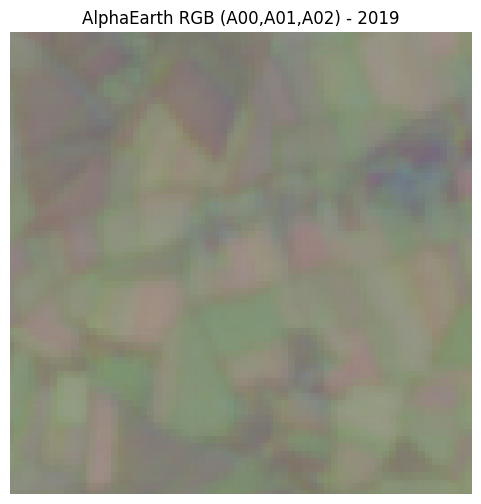

In [4]:
import ee
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# --- Crear imagen RGB sintética usando 3 bandas ---
rgb = img.select(['A11', 'A32', 'A63'])

# --- Definir parámetros del thumbnail ---
region = pt.buffer(640).bounds()  # 200 m alrededor del punto
params = {
    'region': region.getInfo()['coordinates'],
    'dimensions': [128,128],     # tamaño de la imagen en píxeles
    'min': -1,
    'max': 1,
    'format': 'png'
}

# --- Obtener la URL del thumbnail y descargarlo ---
url = rgb.getThumbURL(params)
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# --- Mostrar con matplotlib ---
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.title(f'AlphaEarth RGB (A00,A01,A02) - {year}')
plt.show()

Forma (filas, columnas): (2433, 7)


Fold              int64
ID_PATCH          int64
N_Parcel          int64
Parcel_Cover    float64
TILE             object
dates-S2         object
id               object
dtype: object

Forma de los datos: (43, 10, 128, 128)
ID del parche: 10000
Mostrando t=15 · Fecha=2019-02-26


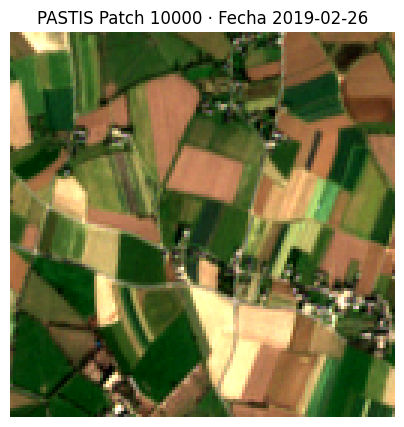

In [5]:
import numpy as np
import pandas as pd
import re, matplotlib.pyplot as plt
import json


# Ruta al GeoJSON de metadatos de PASTIS
metadata_path = "../PASTIS/PASTIS/metadata.geojson"

# 1) Leer el GeoJSON en memoria
with open(metadata_path, "r", encoding="utf-8") as f:
    metadata_json = json.load(f)

# 2) Extraer solo los "properties" de cada parche (feature)
records = [feat["properties"] for feat in metadata_json["features"]]

# 3) Pasar a DataFrame: cada fila = parche, cada columna = atributo del metadato
metadata_df = pd.DataFrame(records)

# 4) Vista rápida de la estructura de los metadatos
print("Forma (filas, columnas):", metadata_df.shape)
display(metadata_df.dtypes)       # tipos de cada columna
metadata_df.head()                # primeras filas

# --- 1) Selecciona el archivo y carga datos ---
chosen_img = 'S2_10000.npy'
data = np.load(f'../PASTIS/PASTIS/DATA_S2/{chosen_img}')  # (T, C, H, W)
print("Forma de los datos:", data.shape)

# --- 2) Extraer ID del parche ---
id_patch = int(re.search(r'S2_(\d+)', chosen_img).group(1))
print(f"ID del parche: {id_patch}")

# --- 3) Filtrar el DataFrame de metadatos ---
patch_data = metadata_df[metadata_df['ID_PATCH'] == id_patch]
dates_raw = patch_data['dates-S2'].iloc[0]   # {'0': 20180924, '1': 20180929, ...}
dates = {int(k): pd.to_datetime(str(v), format="%Y%m%d") for k, v in dates_raw.items()}

# --- 4) Seleccionar un índice temporal (t) ---
t = 15  # cambia este número para elegir otra fecha
fecha = dates[t].date().isoformat()
print(f"Mostrando t={t} · Fecha={fecha}")

# --- 5) Función RGB simple (bandas B4,B3,B2) ---
def get_rgb_from_pastis(data, t, bands=(2,1,0), p_lo=2, p_hi=98):
    cube = data[t, list(bands)]  # (3, H, W)
    vmin, vmax = np.nanpercentile(cube, [p_lo, p_hi])
    rgb = np.clip((cube - vmin) / (vmax - vmin + 1e-9), 0, 1)
    return np.moveaxis(rgb, 0, -1)  # (H, W, 3)

# --- 6) Visualizar la imagen seleccionada ---
rgb = get_rgb_from_pastis(data, t)
plt.figure(figsize=(5,5))
plt.imshow(rgb)
plt.axis('off')
plt.title(f'PASTIS Patch {id_patch} · Fecha {fecha}', fontsize=12)
plt.show()


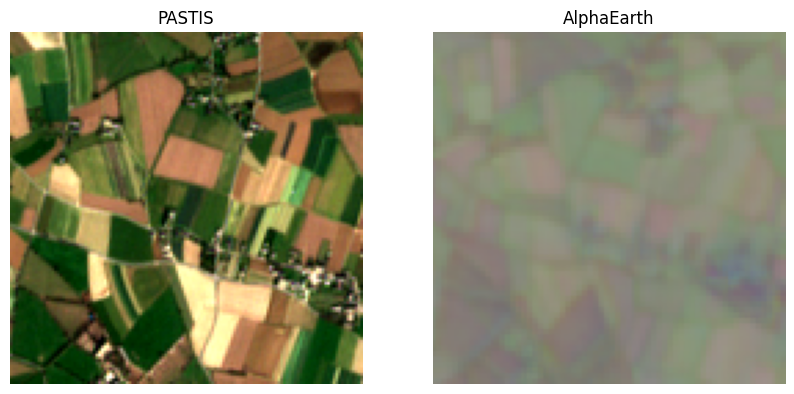

In [6]:
import matplotlib.pyplot as plt

# Convertir la imagen de AlphaEarth (PIL) a array para mostrar con matplotlib
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title("PASTIS")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(np.fliplr(np.rot90(np.array(image), 2)))
plt.title("AlphaEarth")
plt.axis("off")

plt.show()


In [57]:
# pip install earthengine-api geemap
import ee, geemap

# ee.Authenticate()  # solo la primera vez en el entorno
ee.Initialize(project='fonseca-472504')

ASSET = 'projects/fonseca-472504/assets/10000'  # <-- tu asset

# Cargar como FeatureCollection (una tabla subida desde CSV/WKT o GeoJSON se ingesta como FC)
fc = ee.FeatureCollection(ASSET)

# Si es una sola fila, toma la primera; si son varias, usa fc.geometry() para la unión
feature = ee.Feature(fc.first())
geometry = feature.geometry()      # <- esta es la ee.Geometry que quieres

# (Opcional) ver propiedades y algunos derivados
print('Campos:', feature.propertyNames().getInfo())
print('Área (ha):', geometry.area(maxError=1).divide(10000).getInfo())
print('BBox:', geometry.bounds(10).coordinates().getInfo())
print('Centroide:', geometry.centroid(10).coordinates().getInfo())

# (Opcional) visualizar en mapa
m = geemap.Map()
m.centerObject(geometry, 14)
m.addLayer(geometry, {'color': 'red'}, 'Patch 10000', False)
m



Campos: ['patch_id', 'system:index']
Área (ha): 163.36639441845315
BBox: [[[-1.2707396440907253, 49.62353583958773], [-1.2526136239319814, 49.62353583958773], [-1.2526136239319814, 49.63530969092784], [-1.2707396440907253, 49.63530969092784], [-1.2707396440907253, 49.62353583958773]]]
Centroide: [-1.2616776789326578, 49.62942309333302]


Map(center=[49.62942309333302, -1.2616776789326578], controls=(WidgetControl(options=['position', 'transparent…

In [60]:
import ee, geemap
ee.Initialize(project='fonseca-472504')

ASSET = 'projects/fonseca-472504/assets/10000'
fc = ee.FeatureCollection(ASSET)
geom = fc.geometry()

m = geemap.Map()
m.centerObject(geom, 14)

outline = ee.Image().byte().paint(geom, 1, 3)  # valor=1, ancho=3 px
m.addLayer(outline.visualize(palette=['red']), {}, 'Patch 10000 (outline)', True)

m


Map(center=[49.629423093378925, -1.261677678896445], controls=(WidgetControl(options=['position', 'transparent…

In [61]:
# pip install earthengine-api geemap
import ee, geemap
# ee.Authenticate()  # solo la primera vez
ee.Initialize(project='fonseca-472504')

ASSET = 'projects/fonseca-472504/assets/10000'
YEAR = 2022
start = ee.Date.fromYMD(YEAR, 1, 1)
end   = start.advance(1, 'year')

# 1) Geometría desde tu asset (FeatureCollection)
fc   = ee.FeatureCollection(ASSET)
geom = fc.geometry()

# 2) Cargar embeddings anuales y filtrar por año y geometría
embeddings = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL') \
    .filterDate(start, end) \
    .filterBounds(geom)

# (opcional) Validación rápida
if embeddings.size().getInfo() == 0:
    raise ValueError("No hay embeddings para ese año/región (revisa YEAR o la ubicación).")

# 3) Imagen final (64 bandas A00..A63) y recorte al parche
emb_img = embeddings.mosaic().clip(geom)

# 4) Mapa con el parche y una vista RGB de 3 ejes del embedding
m = geemap.Map()
m.centerObject(geom, 14)

# Borde rojo del parche (por si el vector no se dibuja)
outline = ee.Image().byte().paint(geom, 1, 3)
m.addLayer(outline.visualize(palette=['red']), {}, 'Patch outline', True)

# Visualización: elegir 3 bandas del embedding como RGB
vis = {'bands': ['A01', 'A16', 'A09'], 'min': -0.3, 'max': 0.3}
m.addLayer(emb_img, vis, f'Embeddings {YEAR}', True)
m  # o display(m) en Jupyter


Map(center=[49.62942309339125, -1.2616776789146844], controls=(WidgetControl(options=['position', 'transparent…

In [64]:
# pip install earthengine-api geemap
import ee, geemap
# ee.Authenticate()  # solo la primera vez
ee.Initialize(project='fonseca-472504')

# -------- CONFIG --------
ASSET   = 'projects/fonseca-472504/assets/10000'  # tu asset
YEAR    = 2022
K       = 6       # nº de clusters (ajústalo: 4–10 suele ir bien)
SAMPLE  = 8000    # nº de píxeles para entrenar K-means
SCALE   = 10      # resolución del embedding (10 m)
BANDS   = [f'A{i:02d}' for i in range(64)]

# -------- GEOMETRÍA --------
fc   = ee.FeatureCollection(ASSET)
geom = fc.geometry()

# -------- EMBEDDING ANUAL --------
start = ee.Date.fromYMD(YEAR, 1, 1)
end   = start.advance(1, 'year')
emb_img = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
           .filterDate(start, end)
           .filterBounds(geom)
           .mosaic()
           .select(BANDS)
           .clip(geom))

# Comprobación rápida
if emb_img.bandNames().size().getInfo() != 64:
    raise ValueError("No encontré el embedding anual (o faltan bandas). Revisa el YEAR o la ubicación.")

# -------- ENTRENAMIENTO K-MEANS --------
training = emb_img.sample(
    region=geom,
    scale=SCALE,
    numPixels=SAMPLE,
    seed=42,
    geometries=False
)

clusterer = ee.Clusterer.wekaKMeans(K).train(training)
clusters = emb_img.cluster(clusterer).rename('cluster').clip(geom)

# -------- VISUALIZACIÓN --------
m = geemap.Map()
m.centerObject(geom, 14)

# Borde del parche
outline = ee.Image().byte().paint(geom, 1, 3)
m.addLayer(outline.visualize(palette=['red']), {}, 'Patch outline', True)

# Paleta simple para K clases
palette = ['#440154','#31688e','#35b779','#fde725','#ff7f00',
           '#a51f99','#4daf4a','#984ea3','#e41a1c','#377eb8'][:K]
m.addLayer(clusters, {'min':0, 'max':K-1, 'palette': palette}, f'KMeans K={K}', True)
m  # en Jupyter/Colab usa display(m)

# -------- ESTADÍSTICAS (área por cluster) --------
# Sumamos área por grupo (cluster)
areas = (ee.Image.pixelArea().addBands(clusters)
         .reduceRegion(
            reducer=ee.Reducer.sum().group(groupField=1, groupName='cluster'),
            geometry=geom, scale=SCALE, maxPixels=1e13, tileScale=4))

groups = ee.List(areas.get('groups')).getInfo()   # [{cluster:0, sum: m2}, ...]
total_m2 = sum(g['sum'] for g in groups)
print("Área por cluster (m² y %):")
for g in sorted(groups, key=lambda x: x['cluster']):
    pct = 100.0 * g['sum'] / total_m2 if total_m2 else 0
    print(f" - C{g['cluster']}: {int(g['sum']):,} m²  ({pct:5.2f} %)")

# -------- (OPCIONAL) EXPORTAR A DRIVE --------
# Descomenta si quieres el GeoTIFF de clases
# task = ee.batch.Export.image.toDrive(
#     image=clusters,
#     description=f'clusters_{YEAR}_k{K}_patch10000',
#     folder='GEE_exports',
#     region=geom,
#     scale=SCALE,
#     maxPixels=1e13
# )
# task.start()
# print("Export iniciada a Drive: carpeta 'GEE_exports'")
m


Área por cluster (m² y %):
 - C0: 306,238 m²  (18.68 %)
 - C1: 144,019 m²  ( 8.79 %)
 - C2: 391,335 m²  (23.88 %)
 - C3: 283,496 m²  (17.30 %)
 - C4: 236,164 m²  (14.41 %)
 - C5: 277,780 m²  (16.95 %)


Map(center=[49.62942309339125, -1.2616776789146844], controls=(WidgetControl(options=['position', 'transparent…